In [5]:
import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats
import seaborn as sn

from matplotlib import pyplot as plt

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

sn.set(rc={'figure.figsize':(11.7,8.27)})

In [6]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [7]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [8]:
metrics =  [
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    #'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    #'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity',
    'Model Parameter Randomisation'
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed
    
transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': abs,
    'Faithfulness Correlation': abs, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

group_nemenyi = {}

dataset = "imagenet"
for metr in metrics:
    data_nemenyi = pd.DataFrame()
    print("-- Metric: ", metr)
    for meth in methods:
        csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
        df = pd.read_csv(csv_name, header = None)
        data_nemenyi[meth] = transform[metr](df).values.flatten()

    #data_nemenyi = transform[metr](data_nemenyi)
    
    ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
    average_ranks = np.mean(ranks, axis=0)
    
    dico_ranks[metr] = average_ranks/len(metrics)
    
    result = sp.posthoc_nemenyi_friedman(data_nemenyi)
    #Order of methods is changed after being passed to the previous function
    #So reindex them before getting the groups from Nemenyi
    
    group_nemenyi[metr] = np.argwhere(result.reindex(methods)[methods].values > 0.005)

df_ranks = pd.DataFrame(dico_ranks, index= methods)

#compute_plot_Nemenyi(data= data_nemenyi, filename= metr)

-- Metric:  Monotonicity Nguyen
-- Metric:  Local Lipschitz Estimate
-- Metric:  Faithfulness Estimate
-- Metric:  Faithfulness Correlation
-- Metric:  Avg-Sensitivity
-- Metric:  Max-Sensitivity
-- Metric:  Sparseness
-- Metric:  EffectiveComplexity
-- Metric:  Complexity
-- Metric:  Pixel-Flipping
-- Metric:  Selectivity
-- Metric:  Model Parameter Randomisation


In [9]:
df_ranks

,Monotonicity Nguyen,Local Lipschitz Estimate,Faithfulness Estimate,Faithfulness Correlation,Avg-Sensitivity,Max-Sensitivity,Sparseness,EffectiveComplexity,Complexity,Pixel-Flipping,Selectivity,Model Parameter Randomisation
integratedgrad,0.534792,0.152667,0.563667,0.523125,0.204917,0.204958,0.188208,0.282125,0.187292,0.400125,0.338375,0.761125
smoothgrad,0.368479,0.306292,0.428500,0.488000,0.083333,0.083333,0.593083,0.696917,0.604792,0.522000,0.435667,0.167333
guidedbackprop,0.481000,0.125083,0.657750,0.542750,0.213292,0.213292,0.093583,0.179958,0.092500,0.249542,0.422875,0.802333
rise,0.538646,0.786292,0.419417,0.466875,0.866125,0.866208,0.870333,0.685479,0.866000,0.516583,0.463250,0.486833
gradcam,0.386917,0.521208,0.390667,0.469250,0.442250,0.442333,0.393250,0.295354,0.390208,0.614125,0.626333,0.447500
scorecam,0.408646,0.582125,0.420792,0.474792,0.489333,0.489292,0.516167,0.490146,0.512250,0.635375,0.618000,0.438917
layercam,0.398208,0.775083,0.417250,0.488833,0.656000,0.656208,0.714750,0.696917,0.712750,0.605083,0.614292,0.470167
random,0.721396,0.683542,0.849792,0.557500,0.599542,0.599250,0.565792,0.585229,0.554958,0.372958,0.318708,0.772792
sobel,0.662083,0.261042,0.507917,0.525708,0.858167,0.858125,0.271000,0.498521,0.272333,0.437167,0.474875,0.474542
gaussian,0.587250,0.887000,0.412083,0.494042,0.751042,0.751042,0.854083,0.696917,0.859000,0.573542,0.596583,0.128792


In [10]:
tau_values = []
p_values = []

for metric_a in metrics:
    current_tau_values = []
    current_p_values = []
    for metric_b in metrics:
        tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
        current_tau_values.append(tau)
        current_p_values.append(p_value)
    tau_values.append(current_tau_values)
    p_values.append(current_p_values)

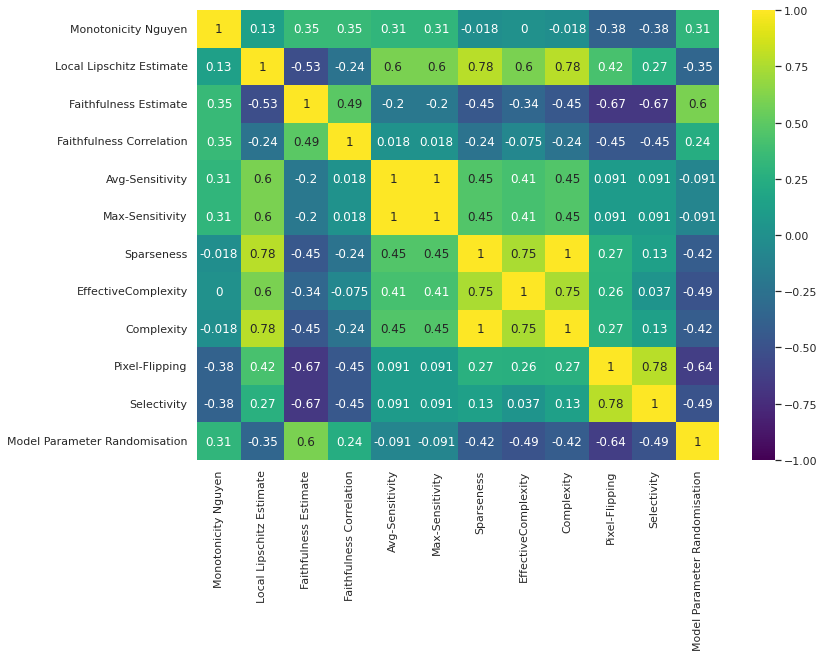

In [11]:
# Correlation Matrix
sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics,
           yticklabels=metrics,
           cmap='viridis')
plt.show()

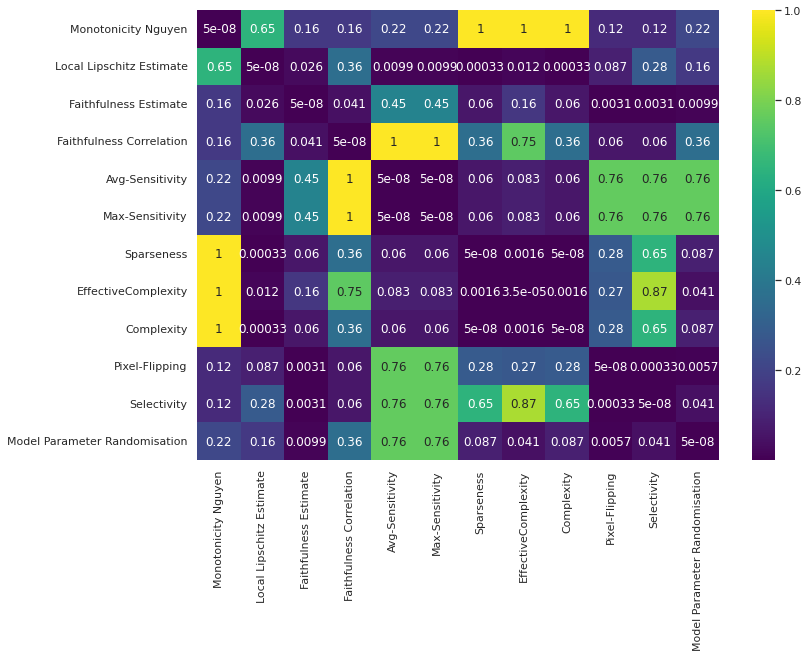

In [12]:
# Matrix of the p_values
sn.heatmap(p_values, annot=True, xticklabels=metrics, yticklabels=metrics, cmap='viridis')
plt.show()

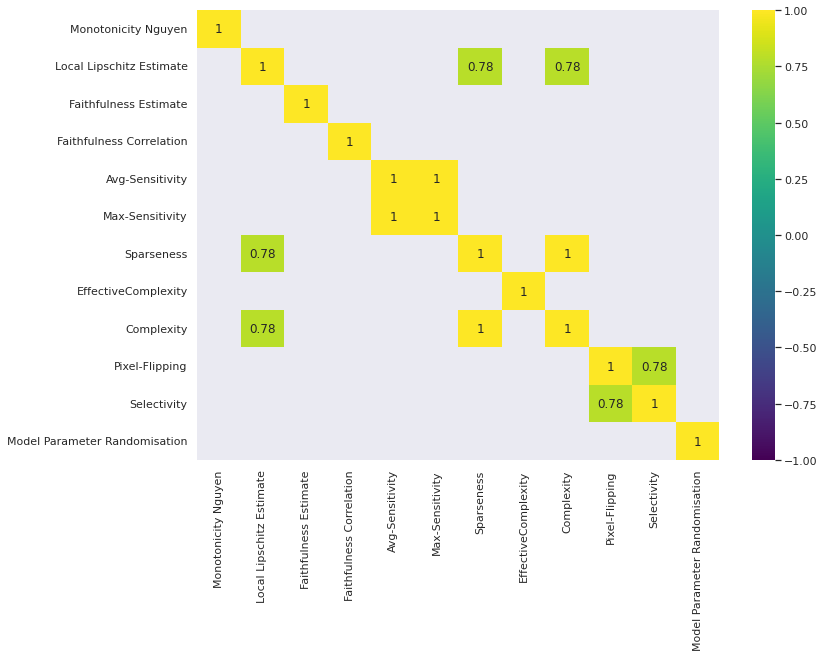

In [13]:
# Correlation Matrix with only significative values (Bonferroni Correction)
p_threshold = 0.05 / len(metrics) ** 2 
p_values_mask = []
for sublist in p_values:
    p_values_mask.append([p_value > p_threshold for p_value in sublist])
    
p_values_mask = np.array(p_values_mask)

sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics,
           yticklabels=metrics,
           mask=p_values_mask,
           cmap='viridis')
plt.show()

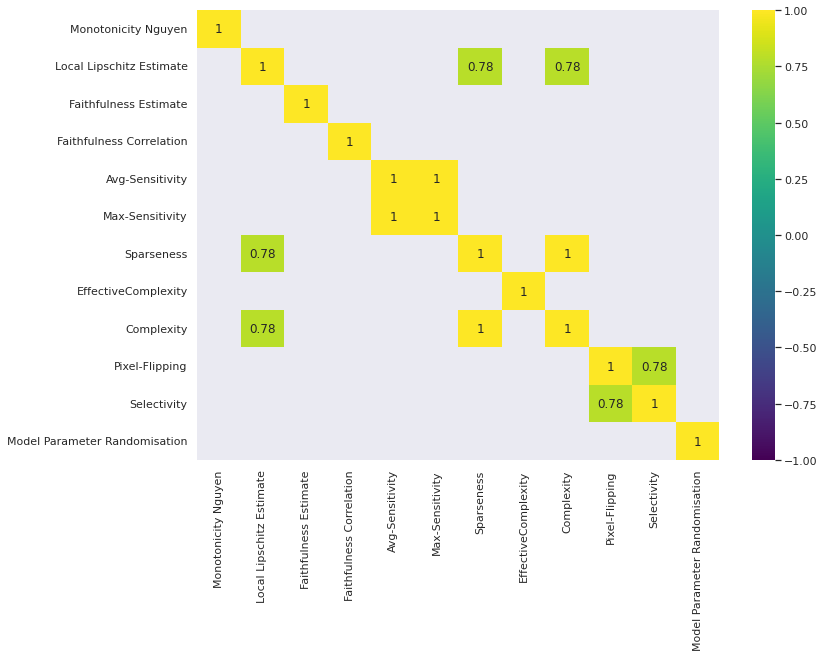

In [14]:
# Correlation Matrix with only significative values (Holm Correction)
from statsmodels.stats.multitest import multipletests

p_values_flattened = [p_value for sublist in p_values for p_value in sublist]
reject, pvals_corrected, _, alphacBonf = multipletests(p_values_flattened,
                                                       alpha=0.05,
                                                       method='holm')

sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics,
           yticklabels=metrics,
           mask=np.invert(reject).reshape((12,12)),
           cmap='viridis')
plt.show()